In [1]:
pip install h2o

Note: you may need to restart the kernel to use updated packages.


In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h2o
from h2o.automl import H2OAutoML
import math
import pickle


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import gc
os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
# working_directory = 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\'  ## 서로 다른 환경에서는 이곳을 수정해야 함.
working_directory = 'C:\\Users\\user\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\'

os.chdir(working_directory)
gc.collect()


0

In [3]:
# RMSPE 계산 함수
def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true))))

# Updated dataset

In [4]:
# df_2 = pd.read_parquet('/content/drive/MyDrive/트머프/my.parquet')
# df_2.head()

# combined_result_df = pd.read_csv("./DB/professor_BTC_sum_both_10m.csv")
df3 = pd.read_csv("./output/BTC_sum_plus_nn_features.csv")
df3.head()


,window_start,window_end,realized_volatility,num_trades,lowest_return,highest_return,high_low_gap,trade_vol,volume_power,end_price,...,liq_last_5_nn16_liq_last_5_m_p2_mean,liq_last_5_nn16_liq_last_1_m_p2_mean,liq_last_5_nn16_liq_last_1two_c_mean,liq_last_5_nn16_two_m_mean,liq_last_5_nn16_sev_high_nn_m_mean,liq_last_5_nn16_sev_low_nn_m_mean,liq_last_5_nn16_sev_high_abs_nn_m_mean,liq_last_5_nn16_sev_low_abs_nn_m_mean,liq_last_5_nn16_all_nn_m_p1_mean,liq_last_5_nn16_all_nn_m_p2_mean
0,2022-12-16 21:44:00,2022-12-16 21:54:00,0.000105,2.575188,-0.000089,0.001815,0.001904,1.138501,1.442885,22599000.0,...,-2.457420,-2.372847,-2.766280,-2.758222,-2.952985,-2.792457,-2.963347,-3.176810,-2.441981,-2.424323
1,2022-12-16 21:45:00,2022-12-16 21:55:00,0.000107,2.557507,-0.000089,0.001815,0.001904,1.100893,1.262884,22596000.0,...,-2.687426,-2.631812,-2.784041,-2.821835,-2.923107,-2.670801,-3.025610,-3.007587,-2.668516,-2.681556
2,2022-12-16 21:46:00,2022-12-16 21:56:00,0.000106,2.562293,0.000000,0.001815,0.001815,1.124306,1.278754,22599000.0,...,-2.635667,-2.568762,-2.763983,-2.735331,-2.789229,-2.872797,-2.945574,-3.164921,-2.643197,-2.659035
3,2022-12-16 21:47:00,2022-12-16 21:57:00,0.000113,2.545307,-0.000089,0.001726,0.001815,1.111548,1.224789,22600000.0,...,-3.102965,-3.124761,-3.046812,-3.010512,-2.927282,-2.925698,-2.925204,-3.133767,-3.050849,-3.119284
4,2022-12-16 21:48:00,2022-12-16 21:58:00,0.000110,2.559907,0.000000,0.001771,0.001771,1.164786,1.104497,22600000.0,...,-2.743898,-2.620030,-3.114678,-3.045498,-2.804784,-2.973736,-2.810906,-3.157707,-2.727709,-2.724700


In [ ]:
# with open('/content/drive/MyDrive/트머프/import.pkl', 'rb') as f:
#     selected_features = pickle.load(f)

# # 128개의 Feature만 사용
# selected_features = selected_features[:128].to_list()

In [ ]:
# selected_features.append('dv1_realized_volatility')

In [ ]:
# df_22 = df_2[selected_features]

In [ ]:
## df_22 = df_2.drop(['time_id', 'window_start', 'window_end'], axis=1)

# numeric_df_2 = df_22.select_dtypes(include=[np.number])
# inf_columns = np.isinf(numeric_df_2).any()

# columns_with_inf = inf_columns[inf_columns].index

# for col in columns_with_inf:
#     df_22[col] = df_22[col].replace([np.inf, -np.inf], np.nan)

# df_22.fillna(df_22.mean(), inplace=True)

<ipython-input-10-fe31ec7800d9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22.fillna(df_22.mean(), inplace=True)


NameError: name 'java' is not defined

In [11]:
import locale

# Set the locale to UTF-8
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,11 mins 15 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_user_q7cq7y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.699 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [12]:
X_col = df3.drop('dv1_realized_volatility', axis=1).columns
y_col = 'dv1_realized_volatility'


train, test = train_test_split(df3, test_size=0.2, shuffle=False)

In [13]:
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████ (cancelled) 100%


In [ ]:
aml_2 = H2OAutoML(seed=1,max_runtime_secs=2400, project_name = 'timeseries_forcasting_v')
aml_2.train(x=list(X_col), y=y_col, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,90.0,90.0,234119.0,13.0,15.0,14.866667,37.0,349.0,201.7
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-08-29 04:11:48,0.035 sec,0.0,0.0000833,0.0000642,0.0000000,0.0000819,0.0000632,0.0000000
,2023-08-29 04:11:56,8.443 sec,5.0,0.0000634,0.0000488,0.0000000,0.0000627,0.0000484,0.0000000
,2023-08-29 04:12:01,13.365 sec,10.0,0.0000534,0.0000402,0.0000000,0.0000538,0.0000407,0.0000000
,2023-08-29 04:12:07,19.907 sec,15.0,0.0000482,0.0000353,0.0000000,0.0000497,0.0000366,0.0000000
,2023-08-29 04:12:12,24.576 sec,20.0,0.0000453,0.0000324,0.0000000,0.0000481,0.0000345,0.0000000
,2023-08-29 04:12:18,30.496 sec,25.0,0.0000435,0.0000306,0.0000000,0.0000472,0.0000334,0.0000000
,2023-08-29 04:12:23,35.351 sec,30.0,0.0000421,0.0000295,0.0000000,0.0000467,0.0000328,0.0000000
,2023-08-29 04:12:27,39.718 sec,35.0,0.0000411,0.0000287,0.0000000,0.0000465,0.0000326,0.0000000


In [ ]:
lb = aml_2.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_1_20230829_41136,4.58346e-05,2.10081e-09,3.21213e-05,4.58244e-05,2.10081e-09
GBM_3_AutoML_1_20230829_41136,4.60562e-05,2.12117e-09,3.20438e-05,4.60459e-05,2.12117e-09
GBM_4_AutoML_1_20230829_41136,4.61376e-05,2.12868e-09,3.2055e-05,4.61273e-05,2.12868e-09
GBM_2_AutoML_1_20230829_41136,4.61386e-05,2.12877e-09,3.23369e-05,4.61284e-05,2.12877e-09
GBM_grid_1_AutoML_1_20230829_41136_model_4,4.63626e-05,2.14949e-09,3.2508e-05,4.63523e-05,2.14949e-09
GBM_grid_1_AutoML_1_20230829_41136_model_6,4.64003e-05,2.15298e-09,3.29368e-05,4.639e-05,2.15298e-09
GBM_grid_1_AutoML_1_20230829_41136_model_5,4.6543e-05,2.16625e-09,3.23891e-05,4.65327e-05,2.16625e-09
GBM_grid_1_AutoML_1_20230829_41136_model_3,4.67301e-05,2.1837e-09,3.3211e-05,4.67197e-05,2.1837e-09
GBM_5_AutoML_1_20230829_41136,4.67891e-05,2.18922e-09,3.30702e-05,4.67786e-05,2.18922e-09
GBM_grid_1_AutoML_1_20230829_41136_model_1,4.73629e-05,2.24324e-09,3.33972e-05,4.73525e-05,2.24324e-09


In [ ]:
predictions = aml_2.leader.predict(test)
y_true = test[y_col].as_data_frame().values.ravel()
y_pred = predictions.as_data_frame().values.ravel()

# RMSPE 계산
score = rmspe(y_true, y_pred)
print("RMSPE:", score)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
RMSPE: 0.3396881802041643


In [ ]:
def plot_range(start, end):
  x_range = range(len(y_true[start:end]))

  plt.figure(figsize=(14,7))

  plt.plot(x_range, y_true[start:end], label='True Values', color='blue')
  plt.plot(x_range, y_pred[start:end], label='Predictions', color='red', linestyle='--')

  plt.title('True Values vs Predictions')
  plt.legend()
  plt.xlabel('Data Point Index')
  plt.ylabel('Value')
  plt.show()

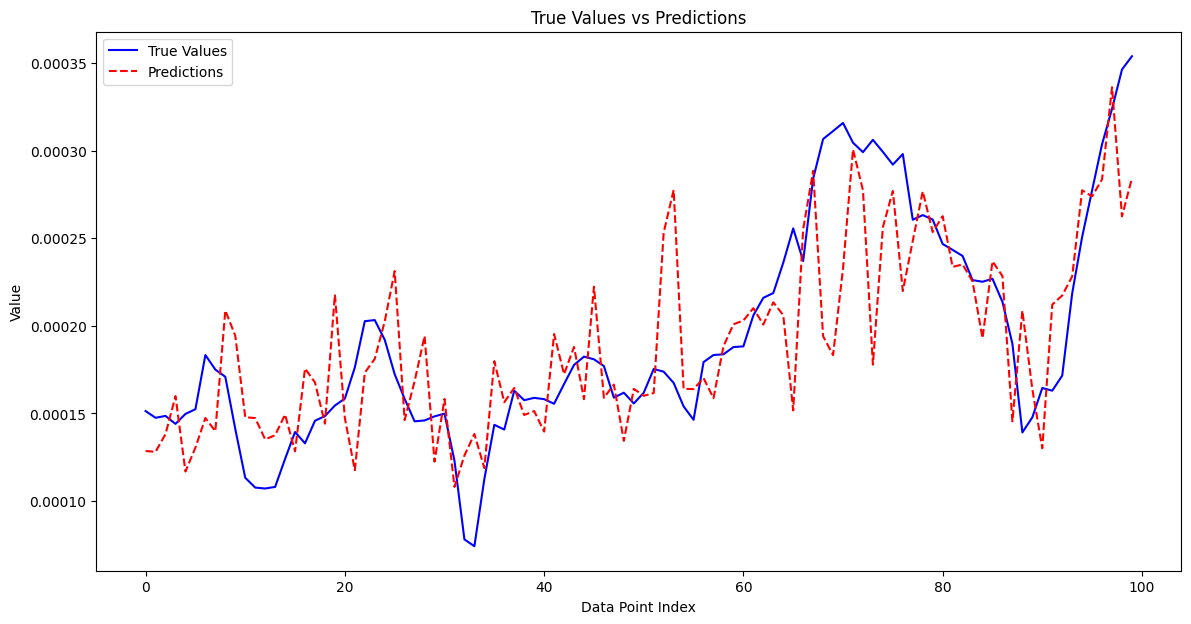

In [ ]:
plot_range(0,100)

In [ ]:
model_path = h2o.save_model(model=aml_2.leader, path="/content/drive/MyDrive/트머프", force=True)


LGBM

In [ ]:
df_2 = pd.read_parquet('/content/drive/MyDrive/트머프/my.parquet')
df_2.head()

,window_start,window_end,realized_volatility,num_trades,lowest_return,highest_return,high_low_gap,trade_vol,volume_power,time_id,...,dv1_realized_volatility_nn64_tvpl5_m_p2_mean,dv1_realized_volatility_nn64_tvpl10_m_p2_mean,dv1_realized_volatility_nn64_tvpl10two_c_mean,dv1_realized_volatility_nn64_two_m_mean,dv1_realized_volatility_nn64_sev_high_nn_m_mean,dv1_realized_volatility_nn64_sev_low_nn_m_mean,dv1_realized_volatility_nn64_sev_high_abs_nn_m_mean,dv1_realized_volatility_nn64_sev_low_abs_nn_m_mean,dv1_realized_volatility_nn64_all_nn_m_p1_mean,dv1_realized_volatility_nn64_all_nn_m_p2_mean
0,2022-12-16 21:06,2022-12-16 21:16,0.000148,2.595496,-0.000842,0.000044,0.000886,1.192050,-1.5249662010,2022-12-16 21:06,...,0.000164,0.000179,0.000147,0.000148,0.000143,0.000184,0.000165,0.000159,0.000129,0.000133
1,2022-12-16 21:07,2022-12-16 21:17,0.000139,2.599883,-0.000842,-0.000133,0.000709,1.156965,-1.8610476860,2022-12-16 21:07,...,0.000158,0.000187,0.000163,0.000161,0.000154,0.000156,0.000143,0.000167,0.000137,0.000131
2,2022-12-16 21:08,2022-12-16 21:18,0.000141,2.571709,-0.000177,0.000443,0.000621,0.996534,-2.3540368030,2022-12-16 21:08,...,0.000183,0.000195,0.000167,0.000166,0.000136,0.000154,0.000147,0.000155,0.000138,0.000140
3,2022-12-16 21:09,2022-12-16 21:19,0.000147,2.542825,-0.000089,0.000488,0.000576,0.909188,-1.6542648970,2022-12-16 21:09,...,0.000214,0.000194,0.000153,0.000149,0.000139,0.000144,0.000151,0.000177,0.000146,0.000153
4,2022-12-16 21:10,2022-12-16 21:20,0.000137,2.552668,-0.000089,0.000488,0.000576,0.918021,-1.8207306230,2022-12-16 21:10,...,0.000184,0.000186,0.000148,0.000144,0.000130,0.000124,0.000102,0.000169,0.000097,0.000100


In [ ]:
with open('/content/drive/MyDrive/트머프/import.pkl', 'rb') as f:
    selected_features = pickle.load(f)

# 512개의 Feature만 사용
selected_features = selected_features[:128].to_list()

In [ ]:
selected_features.append('dv1_realized_volatility')
df_22 = df_2[selected_features]

# numeric_df_2 = df_22.select_dtypes(include=[np.number])
inf_columns = np.isinf(df_22).any()

columns_with_inf = inf_columns[inf_columns].index

for col in columns_with_inf:
    df_22[col] = df_22[col].replace([np.inf, -np.inf], np.nan)

df_22.fillna(df_22.mean(), inplace=True)

<ipython-input-5-e32bd7ba0bb7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22.fillna(df_22.mean(), inplace=True)


In [ ]:
X = df_22.drop('dv1_realized_volatility', axis=1)
y = df_22['dv1_realized_volatility']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)

In [ ]:
# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)

In [ ]:
params = {
    'objective': 'regression',  # 회귀 문제
    'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
    'metric': 'l2',             # Mean Squared Error
    'num_leaves': 100,          # 리프 노드의 최대 수 (mean_leaves에 가깝게 설정)
    'min_data_in_leaf': 50,     # 한 리프에 최소한으로 필요한 레코드 수
    'max_depth': 15,            # 최대 깊이 (max_depth에 맞춤)
    'learning_rate': 0.05,      # 학습률
    'feature_fraction': 0.9,    # 트리를 학습할 때마다 선택할 피처의 비율
    'bagging_fraction': 0.8,    # 트리를 학습할 때마다 선택할 데이터의 비율
    'bagging_freq': 5,          # bagging의 빈도
    'n_estimators': 105         # 총 트리의 수 (number_of_trees에 맞춤)
}


In [ ]:
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                early_stopping_rounds=50
                )

# 모델 예측
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# 모델 평가
print('The RMSPE of prediction is:', rmspe(y_test, y_pred))

Starting training...


TypeError: ignored

In [ ]:
def plot_range_lgbm(start, end):
  x_range = range(len(y_test[start:end]))

  plt.figure(figsize=(14,7))

  plt.plot(x_range, y_test[start:end], label='True', color='blue')
  plt.plot(x_range, y_pred[start:end], label='Predictions', color='red', linestyle='--')

  plt.title('True volatility vs Prediction volatility')
  plt.legend()
  plt.xlabel('Data Point Index')
  plt.ylabel('volatility')
  plt.show()

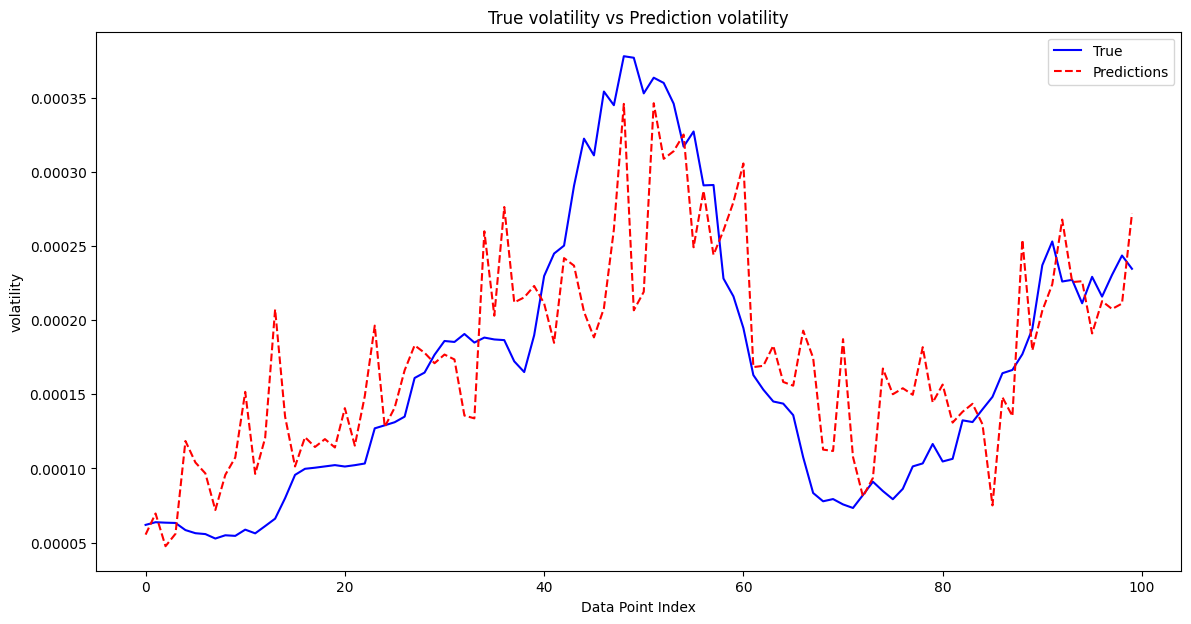

In [ ]:
plot_range_lgbm(0,100)

In [ ]:
nfold = 10
folds = KFold(n_splits=nfold, shuffle = False)

# Placeholder for out of fold predictions

# Create a train dataset
train_data = lgb.Dataset(X_train, y_train)

# Cross validation with early stopping and custom feval
cv_results = lgb.cv(params, train_data, num_boost_round=500, folds=folds, early_stopping_rounds=50,
                    stratified=False, return_cvbooster=True)

TypeError: ignored

In [ ]:
# CV 결과에서 booster 모델들을 가져옴
cvbooster = cv_results['cvbooster']

# 예측을 저장할 배열을 생성
nfold = len(cvbooster.boosters)
predictions = np.zeros(len(X_test))

# 각 fold에 대한 모델로 예측을 수행
for i in range(nfold):
    booster = cvbooster.boosters[i]
    predictions += booster.predict(X_test)

# 예측 결과를 평균내어 최종 예측을 얻음
predictions /= nfold
y_pred = predictions

In [ ]:
rmspe(y_test, y_pred)

0.32644348802962636

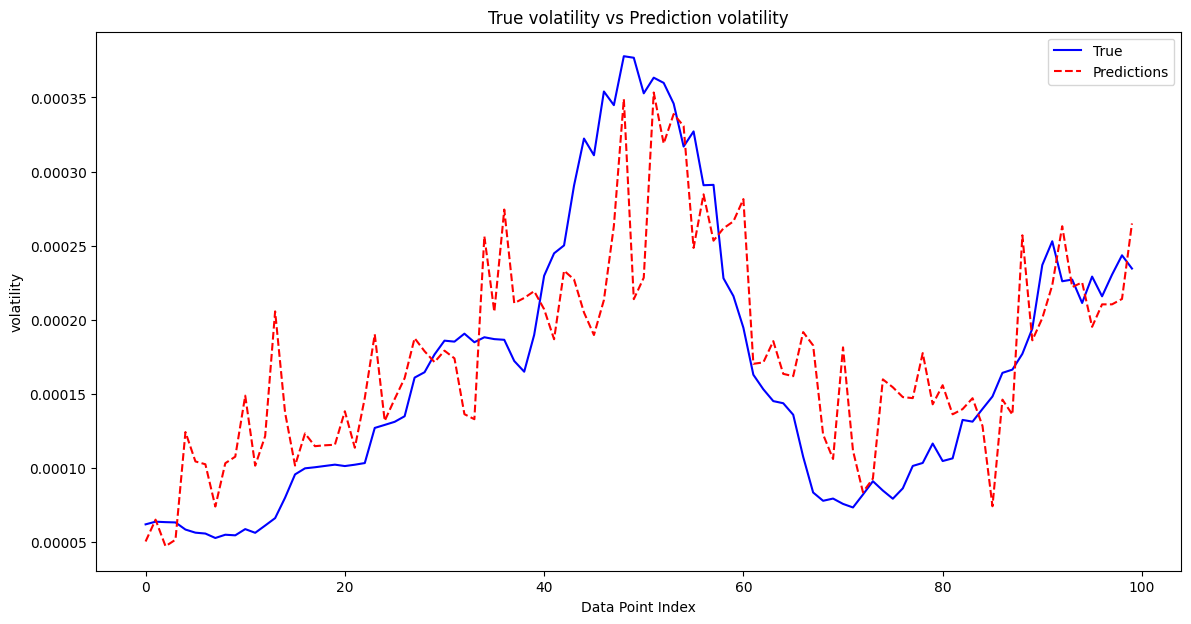

In [ ]:
plot_range_lgbm(0,100)

In [ ]:
y_pred.std()

5.176584496158937e-05